**Materiály vznikají průběžně a jsou bez záruky - prosím o report chyb :-)**

In [6]:
import numpy as np
np.set_printoptions(precision=3)
from sympy import *
from scipy.stats import norm, uniform
import matplotlib.pylab as plt

# Rozdělení součtu nezávislých veličin

## Příklad

**Máme dva sekvenční dotazy do dvou SQL serverů - nejprve je třeba získat v první databázi výsledek, na jehož základě následuje okamžitě dotaz do druhé SQL databáze. Vysledované četnosti doby odpovědí ($D_1, D_2$ pro každý server) byly zaokrouhleny k hodnotám 5, 10 a 15ms. Jejich relativní četnosti vypadají následovně:**

| Doba | $D_1$ | $D_2$ |
|---|---|---|
| 5ms | 30% |  10% |
| 10ms | 60% | 70% |
| 15ms | 10% | 20% |

**Máme určit, jaká bude pravděpodobnost, že oba dotazy budou zodpovězeny během 20ms.**

Jedná se o diskrétní veličiny, budeme tedy hledat

$$
\begin{align}
P(D_1 + D_2 = 20) &= \sum_k P(D_1=x_k) \cdot P(D_2 = 20-x_k)  \\
&= P(D_1=5) P(D_2=15) + P(D_1=10)P(D_2=10) + P(D_1=15)P(D_2=5) \\
&= 0.3 \cdot 0.2 + 0.6\cdot 0.7 + 0.1\cdot 0.1 = 0.49.
\end{align}
$$


Intuitivně jsme "objevili" to, čemu se říká **konvoluce** :)

> **Věta: Rozdělení součtu nezávislých veličin**
>
> Buďte $X$ a $Y$ nezávislé náhodné veličiny a $Z=X+Y$. Potom distribuce $Z$ je dána [konvolucí](https://en.wikipedia.org/wiki/Convolution), konkrétně
>
> jsou-li $X$ a $Y$ diskrétní, pak
>
>$$
P(Z=z)=\sum_k P(X=x_k)\cdot P(Y=z-x_k),
$$
>
> jsou-li $X$ a $Y$ spojité, pak
>$$
f_Z(z)=\int_{-\infty}^{\infty}f_X(x)~f_Y(z-x)dx.
$$


Pokud použijeme konvoluci (`np.convolve()`) na příklad výše, snadno nalezneme rozdělení součtu obou náhodných veličin. Možné součty jsou 10, 15, 20, 25 a 30:

In [2]:
D1 = np.array([.3, .6, .1])
D2 = np.array([.1, .7, .2])
convolution = np.convolve(D1, D2)
sums = np.arange(10, 31, 5)
for s, c in zip(sums, convolution):
    print(f'P(D1+D2 = {s}) = {c:.2f}')

P(D1+D2 = 10) = 0.03
P(D1+D2 = 15) = 0.27
P(D1+D2 = 20) = 0.49
P(D1+D2 = 25) = 0.19
P(D1+D2 = 30) = 0.02


# Limitní věty

> **Věta - [Markovova nerovnost](https://en.wikipedia.org/wiki/Markov%27s_inequality)**
>
> Nechť $X$ je náhodná veličina s konečnou střední hodnotou. Potom pro každé $a>0$ platí
>
>$$
P(|X|\geq a) \leq \frac{E|X|}{a}.
$$

### Příklad
Pingáme webserver fakulty:

    [root@moebius ~]# hping3 -i u100 -c 100 -S -q www.fit.cvut.cz
    HPING www.fit.cvut.cz (wlan0 147.32.232.248): S set, 40 headers + 0 data bytes

    --- www.fit.cvut.cz hping statistic ---
    100 packets transmitted, 100 packets received, 0% packet loss
    round-trip min/avg/max = 21.7/41.6/55.7 ms

Průměrnou dobu odezvy použijeme jako střední hodnotu (přesněji řečeno, jako její odhad). Jaká je pravděpodobnost, že round-trip time bude větší jak 50ms?

In [3]:
print('Podle Markovovy nerovnosti P(T>50) <= {0:.2f}'.format(41.6/50))

Podle Markovovy nerovnosti P(T>50) <= 0.83


> **Věta - [Čebyševova nerovnost](https://en.wikipedia.org/wiki/Chebyshev's_inequality)**
>
> Nechť $X$ je náhodná veličina s konečnou střední hodnotou a konečným rozptylem. Potom pro každé $\varepsilon>0$ platí
>
>$$
P(|X-EX|\geq \varepsilon) \leq \frac{\operatorname{var}X}{\varepsilon^2}.
$$

Nerovnost je častěji ve formě

$$
P(|X-EX|\geq k\sigma) \leq \frac{1}{k^2}.
$$

kde $\sigma$ je směrodatná odchylka (odmocnina variance). To nám dává horní odhad podílu hodnot náhodné veličiny, jež leží ve vzdálenosti větší než $k$ směrodatných odchylek od střední hodnoty. Samozřejmě pokud známe rozdělení, nebudeme počítat Čebyševovou nebo jinou nerovností, ale použijeme distribuční funkci. Například pro normální rozdělení tu máme tzv. "[68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)" (Čebyšev dává pro $2\sigma$ 75% a pro $3\sigma$ 89%).

### Malá příprava na centrální limitní větu :)

Vzpomeňme na standardizaci normálně rozdělené náhodné veličiny $X\sim\mathcal{N}(\mu, \sigma^2)$:

$$
Z = \frac{X - \mu}{\sigma} = \frac{\text{veličina - střední hodnota}}{\text{směrodatná odchylka}}.
$$

Veličina $Z$ má potom rozdělení $\mathcal{N}(0,1)$. Centrální limitní věta - viz níže - potom říká, že ten slovně vyjádřený zlomek lze aplikovat mnohem univerzálněji. Samozřejmě s jistou opatrností, jde jen o konvergenci!

Vezměme si jako příklad soubor $n$ stejně rozdělených nezávislých (iid) veličin se střední hodnotou $EX$ a rozptylem $\operatorname{var}X$. Pro průměr $\bar{X}_n$ a součet $S_n$ evidentně platí (bez důkazu zde):

$$
\bar{X}_n = \frac{1}{n}\sum_{i=1}^n X_i, \qquad E\bar{X}_n = EX_i, \qquad \operatorname{var}\bar{X}_n = \frac{\operatorname{var} X_i}{n}, \\
S_n = \sum_{i=1}^n X_i,\qquad  ES_n = n\cdot EX_i, \qquad\operatorname{var}S_n = n\cdot \operatorname{var} X_i \\
$$

Podívejme se na simulaci, že s rozsahem výběru opravdu klesá variance průměru. Samostatně si můžete ověřit odpovídající tvrzení pro součet iid náhodných veličin.

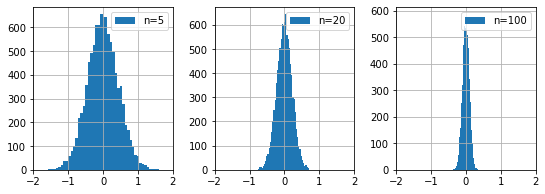

In [10]:
rozsah_vyberu = [5, 20, 100]
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, rozsah in enumerate(rozsah_vyberu):
    x = norm.rvs(size=(rozsah, 10000))    # zkuste uniform.rvs()
    means = x.mean(axis=0)
    axs[i].hist(means, bins=50, label=f'n={rozsah}')
    axs[i].set_xlim((-2,2))
    axs[i].legend()
plt.show()

Dokážete výše uvedené vztahy dosadit do vzorečku pro standardizaci?

> **Centrální limitní věta (CLV, CLT)**
>
> Nechť $X_1, X_2,\dotsc, X_n$ je posloupnost i.i.d. náhodných veličin s konečnou střední hodnotou $EX_i = \mu$ a konečným nenulovým rozptylem $\operatorname{var} X_i = \sigma^2$. Označme součet $S_n = \sum_{i=1}^n X_i$ a průměr $\bar{X}_n = \frac{1}{n}\sum_{i=1}^n X_i$. Potom pro $n\to\infty$ platí
>
> $$
\frac{S_n - n\mu}{\sigma\sqrt{n}} \xrightarrow{D} \mathcal{N}(0,1)
$$
>
> a
>
>$$
\frac{\bar{X}_n - \mu}{\sigma/\sqrt{n}} \xrightarrow{D} \mathcal{N}(0,1).
$$

Evidentně stačilo dosadit :) Lepší, než si pamatovat vzorečky, je umět napsat střední hodnotu a rozptyl (což je snadné si odvodit) a dosadit do jediné pamatováníhodné formulky

$$
Z = \frac{X - EX}{\sqrt{\operatorname{var} X}} \sim \mathcal{N}(0,1).
$$

Všimněme si, že s rostoucím rozsahem výběru

- klesá neurčitost (variance) průměru.
- roste neurčitost (variance) hodnoty součtu.

Zdůvodněte si obojí, je to snadné.

Na prvním faktu je založena většina aplikované statistiky :)

### Příklad

**Použijeme ping z předchozího příkladu. Nyní navíc víme, že směrodatná odchylka RTT pingu je 15ms. Připomeňme, že střední hodnota RTT je 41.6ms. Jaká je pravděpodobnost, že 50 nových pingů bude mít průměrný round-trip time větší než 48ms?**

Víme: 

$$
E\bar{X}_{50} = EX_i = 41.6, \qquad \operatorname{var}\bar{X}_{50} = \frac{15^2}{50}=4.5.
$$

Potom

$$
\begin{align}
P(\bar{X}_{50} > 48) &= 1 - P(\bar{X} \leq 48) \\
&= 1 - P\left(\frac{\bar{X}_{50} - E\bar{X}_{50}}{\sqrt{\operatorname{var}\bar{X}_{50}}} \leq \frac{48 - 41.6}{\sqrt{4.5}} \right)  \\
&= 1 - P(Z \leq 3.017) = 0.0013.
\end{align}
$$

In [4]:
EX = 41.6
varX = 15**2
n = 50
norm.sf(48, loc=EX, scale=np.sqrt(varX/n))

0.0012764956617469449

---

# Příklady ze slajdů

### Příklad 8.1

**Házíme dvěma šestistěnými kostkami.**

- **Modrá kostka je cinknutá tak, že P(sudé) = 2P(liché).**
- **Bílá kostka je cinknutá tak, že P(liché) = 3P(sudé).**

Zde bychom si mohli napočítat pravděpodobnosti, což bychom měli už zvládnout sami. Výsledek je:

$$
\begin{align}
P(X = i) &=
\begin{cases}
\frac{1}{9} &\text{pro}\ i\in\{1,3,5\},\\
\frac{2}{9} &\text{pro}\ i\in\{2,4,6\},
\end{cases}
\\
P(Y = i) &=
\begin{cases}
\frac{1}{12} &\text{pro}\ i\in\{2,4,6\},\\
\frac{3}{12} &\text{pro}\ i\in\{1,3,5\},
\end{cases}
\end{align}
$$

(Pozn.: někdy se hodí zlomky v průběžných výpočtech nezkracovat. Ve výsledku bychom to ale měli dělat vždy.)

**a) Určete pravděpodobnost, že součet ok na modré a bílé kostce bude roven pěti.**

$$
\begin{align}
P(Z = X+Y = z = 5) &= \sum_k P(X=x_k) P(Y=z-x_k) \\
&= P(X=1)P(Y=5-1) + \ldots \\
&= 2\left( \frac{1}{9} \cdot \frac{1}{12} \right) + 2\left(\frac{2}{9}\cdot\frac{3}{12} \right) = \frac{7}{54}.
\end{align}
$$


**b) Nalezněte rozdělení náhodné veličiny určující součet ok na modré a bílé kostce.**

Použijeme konvoluci na všechny součty - viz následující kód.

In [5]:
P_Xl = 1/9        # pst X je liche
P_Xs = 2/9        # pst X je sude
X = np.tile([P_Xl, P_Xs], 3)

P_Yl = 3/12
P_Ys= 1/12
Y = np.tile([P_Yl, P_Ys], 3)

Z = np.convolve(X, Y)
for i, zi in enumerate(Z):
    print('P(Z={0}) = {1:.3f} = {2:g}/108'.format(i+2, Z[i], Z[i]*108))

P(Z=2) = 0.028 = 3/108
P(Z=3) = 0.065 = 7/108
P(Z=4) = 0.074 = 8/108
P(Z=5) = 0.130 = 14/108
P(Z=6) = 0.120 = 13/108
P(Z=7) = 0.194 = 21/108
P(Z=8) = 0.111 = 12/108
P(Z=9) = 0.130 = 14/108
P(Z=10) = 0.065 = 7/108
P(Z=11) = 0.065 = 7/108
P(Z=12) = 0.019 = 2/108


### Příklad 8.2

**Mějme dvě nezávislé stejně rozdělené náhodné veličiny $X\sim\text{Unif}(0,1)$ a $Y\sim\text{Unif}(0,1)$.**

**a) Nalezněte rozdělení náhodné veličiny $Z=X+Y$.**

Použijeme konvoluci,

$$
f_Z(z) = \int_\mathbb{R} f_X(x) f_Y(z-x) dx.
$$

Protože obě hustoty jsou stejné, budeme dále značit $f=f_X=f_Y$. Současně víme, že pro obě zadané hustoty platí

$$
f(\cdot) = 
\begin{cases}
0 &\text{pro argument mimo interval [0,1],}\\
1 &\text{na intervalu [0,1]}.
\end{cases}
$$

Jelikož $x,y\in[0,1]$, rozdělíme si výpočet na dvě části:

i) $z\in[0,1]$. Abychom v konvoluci integrovali něco nenulového, potřebujeme pouze hodnoty, kde je $f(z-x)>0$. Dokonce bude jednoduše platit $f(z-x)=1$, protože podle definice výše víme, že jiných kladných hodnot hustota nenabývá. Musíme se proto pro $z\in[0,1]$ pohybovat v oblasti $z-x\geq 0$, tedy $x\leq z\in[0,1]$. Konvoluční integrál je tedy

$$
f_Z(z) = \int_0^z f(x) f(z-x) dx = \int_0^z 1\cdot 1 = z.
$$

ii) $z\in(1,2]$. Uvažujeme podobně jako předtím: aby $f(z-x)=1$ - jinak je opět nula - musí být $z-x\leq 1$, tedy $x\geq z-1$. Všimněte si, že protože $x\in[0,1]$, dostaneme opravdu $z\in[1,2]$ Potom konvoluční integrál je

$$
f_Z(z) = \int_{z-1}^1 f(x) f(z-x) dx = \int_{z-1}^1 1\cdot 1 dx = 2-z.
$$

Hustota Z tedy je

$$
f_Z(z) = 
\begin{cases}
z &z\in[0,1],\\
2-z &z\in[1,2],\\
0 &\text{jinde}.
\end{cases}
$$

Dá se to i pěkně nakreslit :)

**b) Spočtěte střední hodnotu a rozptyl náhodné veličiny $Z$.**

Výpočet střední hodnoty a variance (připomeňme, $\operatorname{var}Z = EZ^2 - (EZ)^2$ bychom už měli umět na výbornou. Výsledky jsou $EZ=1, \operatorname{var}Z = \frac{1}{6}$.

**+c) Nalezněte rozdělení součtu tří i.i.d. veličin s rozdělením $\text{Unif}(0,1)$.**

Je potřeba provést ještě jednou konvoluci rovnoměrné hustoty s výsledkem z bodu jedna (budeme dělit interval natřikrát). Výsledkem je [Irvinova-Hallova distribuce](https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution), stejně jako v předchozím případě. Výsledek tedy viz odkaz.

### Příklad 8.3

**Nechť $X_1, X_2,\ldots$ je posloupnost i.i.d. náhodných veličin s konečnou střední hodnotou $EX_i = \mu$ a konečným nenulovým rozptylem $\operatorname{var} X_i = \sigma^2$. Položme dále:**

$$
S_n = X_1 + X_2 + \ldots + X_n\quad \text{a}\quad \bar{X_n} = \frac{1}{n} S_n = \frac{1}{n} \sum_{i=1}^n X_i.
$$

**Určete:**

**a) $ES_n$ a $E \bar{X_n}$,**

**b) $\operatorname{var} S_n$ a $\operatorname{var} \bar{X_n}$.**

Oboje je přímá aplikace středních hodnot a variancí, viz přednáška, kde je toto vyřešeno v důkazech.

### Příklad 8.4

**Nechť $X_1,\dots,X_{64}$ jsou stejně rozdělené nezávislé (i.i.d.) náhodné veličiny s $EX_i=6$ a $\operatorname{var}X_i=4$ pro všechna $i = 1,\dots,n$, kde $n = 64$.**

**Určete:**

**a) $P\left(\sum_{i=1}^{64}X_i\leq 360\right)$.**

Rovnou si doplníme:

$$
S_{64} = \sum_{i=1}^{64}X_i, \qquad ES_{64} = n\mu = 64\cdot 6 = 384, \quad \operatorname{var}S_{64} = n\cdot\sigma^2 = 256.
$$

Tedy

$$
P\left( S_{64} \leq 360 \right) = P\left(
\frac{S_{64} - ES_{64}}{\sqrt{\operatorname{var} S_{64}}}
\leq
\frac{360 - ES_{64}}{\sqrt{\operatorname{var} S_{64}}}
\right)
= P\left(Z_{64} \leq -\frac{3}{2}\right) = 0.0668.
$$

Využili jsme symetrii normálního rozdělení, neboť tabulky jsou jen pro kladné argumenty ;) Viz minulé cvičení.

In [6]:
norm.cdf(360, loc=64*6, scale=np.sqrt(64*4))

0.06680720126885807

**b) $P(\bar{X}_n> 6,\!5)$,**

Sepíšeme si

$$
E\bar{X}_n = EX_i = 6, \qquad \operatorname{var}\bar{X}_n = \frac{\operatorname{var}X_i}{n} = \frac{4}{64} = \frac{1}{16}.
$$

Tedy

$$
\begin{aligned}
P(\bar{X}_n > 6.5) &= P\left(\frac{\bar{X}_n - EX_n}{\sqrt{\operatorname{var}\bar{X}_n}} 
\geq 
\frac{6.5 - EX_n}{\sqrt{\operatorname{var}\bar{X}_n}}
\right) \\
&= 1 - P\left(\frac{\bar{X}_n - EX_n}{\sqrt{\operatorname{var}\bar{X}_n}} 
\leq 
\frac{6.5 - EX_n}{\sqrt{\operatorname{var}\bar{X}_n}}
\right) \\
&= 1 - P(Z_n \leq 2)
\end{aligned}
$$

In [18]:
norm.sf(6.5, loc=6, scale=np.sqrt(1/16)) # Survival func., fce přežití

0.022750131948179195

**c) $P(5.2 < \bar{X}_n < 6.9)$,**

Standardizujeme a postupujeme jak jsme zvyklí...

In [8]:
norm.cdf(6.9, loc=6, scale=np.sqrt(1/16)) - \
norm.cdf(5.2, loc=6, scale=np.sqrt(1/16))

0.9991537534719266

**d) $a$ takové, že $P(\bar{X}_n<a)=0.36$,**

$a$ má být kvantil $u_{0.36}$ normálního rozdělení, najdeme tedy tentýž kvantil pro $\mathcal{N}(0,1)$ a transformujeme jej do naší veličiny $\bar{X}_n \sim \mathcal{N}(E\bar{X}_n, \operatorname{var}\bar{X}_n)$.

Jenže tabulky začínají hodnotou 0.5 :) Víme, že $\mathcal{N}(0,1)$ je symetrické, takže $u_{0.36}$ se od $u_{1-0.36}=u_{0.64}\doteq 0.36$ liší jen znaménkem:

In [12]:
print(f'u(0.36) = {norm.ppf(0.36):.4}')
print(f'u(1 - 0.36) = u(0.64) = {norm.ppf(0.64):.4}')

u(0.36) = -0.3585
u(1 - 0.36) = u(0.64) = 0.3585


Pak už stačí jen dosadit do transformace.

In [13]:
norm.ppf(0.36, loc=6, scale=np.sqrt(1/16))

5.910385301687201

**e) $a$ takové, že $P(6-a<\bar{X}_n<6+a)=0.73$.**

A znovu stejně - také bylo na minulém cvičení. Mysleme na to, že jde vlastně o posun střední hodnoty o -6,

$$
P(-a < \bar{X}_n - 6 < a) = 0.73.
$$

A řešíme symetrický případ...

In [10]:
P_na_jeden_chvost = (1 - 0.73)/2
u = norm.ppf(P_na_jeden_chvost, loc=0, scale=1)
a = np.abs(u * np.sqrt(1/16))
print('a = ', a)
norm.cdf(6-a, loc=6, scale=np.sqrt(1/16)) - norm.cdf(6+a, loc=6, scale=np.sqrt(1/16))

# KontrolaK
P = norm.cdf(6+a, loc=6, scale=np.sqrt(1/16)) 
P -= norm.cdf(6-a, loc=6, scale=np.sqrt(1/16))
print('Pro kontrolu, P = ', P)

a =  0.27576563904989937
Pro kontrolu, P =  0.7299999999999993


### Příklad 8.5

**Nosnost lodi je $5000$ kg. Hmotnost cestujícího $X_i$ je náhodná veličina se střední hodnotou $EX_i=70$ kg a směrodatnou odchylkou (odmocnina z rozptylu) $\sqrt{\operatorname{var}X_i} = 20$ kg. Kolik cestujících smíme nalodit, aby pravděpodobnost přetížení lodi byla menší než $0.001$?**

Ptáme se na

$$
P(S_n > 5000) < 0.001.
$$

Víme:

$$
E S_n = n\cdot EX_i, \qquad \operatorname{var}S_n = n\operatorname{var}X_i.
$$

Počítáme

$$
P(S_n > 5000) < 0.001 \quad \text{hledáme přes}\quad P(S_n \leq 5000) = 0.999.
$$

Budeme tedy hledat takový kvantil $u$ standardního normálního rozdělení, pro který platí

$$
P(Z < u) = 0.999.
$$

a ten budeme transformovat do rozdělení pro $S_n$. Pohledem do tabulek vidíme, že $u = 3.09$.

Jelikož neznáme $n$ v proměnné $S_n = n\cdot X_i$, máme

$$
Z = \frac{S_n - ES_n}{\sqrt{\operatorname{var} S_n}}
< 
\frac{5000 - 70n}{20\cdot\sqrt{n}} = u = 3.09.
$$

Dořešením a zaokrouhlením dostaneme $n = 64$.

In [11]:
u = norm.ppf(0.999)
print(u)

n = symbols('n')
solve((5000 - 70*n)/(20*sqrt(n))-u, n)

3.090232306167813


[64.3461097739970]

### Příklad 8.6

**Ve skladu máme 100 "nezávislých" žárovek. Životnost žárovek se řídí exponenciálním rozdělením se střední hodnotou 10 hodin. Vždy svítíme jen jednou žárovkou. Když se porouchá, osadíme ihned novou. Jaká je pravděpodobnost, že tato sada vydrží svítit alespoň 1100 hodin?**

Pro exponenciální rozdělení platí, že $EX_i=\frac{1}{\lambda} = 10$ a $\operatorname{var}X_i = \frac{1}{\lambda^2} = 100$. Nyní podle CLV počítáme

$$
P(S_n > 1100) = 0.16.
$$

Níže je řádek kódu pro funkci přežití, kterou ale v tabulkách nenajdeme ;)

In [12]:
norm.sf(1100, loc=100*10, scale=np.sqrt(100*100))

0.15865525393145707

### Příklad 8.7

**Soukromý FTP server má 100 uživatelů. Střední objem dat každého uživatele je 1200 MB se směrodatnou odchylkou 400 MB. Jak velké musí být diskové pole, aby se na něj vešla všechna data uživatelů s pravděpodobností 99%?**

Máme $EX_i = 1200, \operatorname{var}X_i=400^2, n=100$ a počítáme

$$
P(S_n \leq \tilde{u}) = 0.99.
$$

Hledáme tedy ekvivalent kvantilu $u \equiv u_{0.99}$ normálního rozdělení,

$$
P(Z \leq u) = 0.99,
$$

který následně transformujeme. To už zvládneme sami, správný výsledek je v kódu níže ;)

In [13]:
norm.ppf(0.99, loc=100*1200, scale=np.sqrt(100*400**2))

129305.39149616336

### Příklad 8.8

**Provádíme sérii hodů symetrickou mincí. Kolikrát musíme hodit, aby podíl orlů byl mezi 0.4 a 0.6 s pravděpodobností alespoň 95%?**

Jeden výsledek hodu mincí popisuje alternativní (Bernoulliho) rozdělení s parametry $EX_i = p = 0.5$ a $\operatorname{var}X_i = p(1-p) = 0.5^2$.

Pro $n$ hodů máme

$$
E\bar{X}_n = EX_i = 0.5, \qquad \operatorname{var}\bar{X}_n = \frac{\operatorname{var}X_i}{n} = \frac{0.25}{n}.
$$

Hledáme pravděpodobnostost symetrického intervalu okolo střední hodnoty,

$$
P(0.4 \leq \bar{X}_n \leq 0.6) \geq 0.95,
$$

což je ekvivalentní k hledání symetrického intervalu okolo střední hodnoty standardního normálního rozdělení

$$
P(-u \leq Z \leq +u) = P(u_{0.025} \leq Z \leq u_{0.975}) = 0.95.
$$

Díky symetrii snadno zjistíme, že $u = 1.96$. Nyní musíme transformovat z $N(0,1)$ do $N(E\bar{X}_n, \operatorname{var}\bar{X}_n)$. Díky symetrii si můžeme vybrat jeden z krajů intervalu, např. 0.4:

$$
\frac{0.4 - 0.5}{\sqrt{\frac{0.25}{n}}} = 1.96
$$

a dořešíme rovnici pro $n$. Nezapomeňte, že $n\in\mathbb{N}$, výsledek tedy zaokrouhlíme a zjistíme, že $n\geq 96$.

In [14]:
u = norm.ppf(0.025)
solve((0.4 - 0.5)/sqrt(0.25/n)-u, n)

[96.0364705173527]

### Příklad 8.9

**Pojišťovna uzavřela životní pojistku 1000 zákazníkům. Každý ze zákazníků zaplatil pojistné 1200 korun. Pokud během následujícího roku zákazník zemře, vyplatí pojišťovna pozůstalým 80000 korun. Pravděpodobnost úmrtí zákazníka se odhaduje na 1%. Jaká je pravděpodobnost, že pojišťovna utrpí ztrátu?**

Nejprve musíme zjistit, kolik klientů musí zemřít, aby pojišťovna byla na nule:

In [15]:
prijem = 1200 * 1000
naklad_os = 80000
np.divmod(prijem, naklad_os)

(15, 0)

To je tedy 15 klientů, od tohoto čísla začíná pojišťovně ztráta. Můžeme uvažovat, že úmrtí v příštím roce je bernoulliovská veličina s pravděpodobností $p = 0.01$, tedy současně s $EX_i = p = 0.01$ a $\operatorname{var}X_i = p(1-p) = 0.01\cdot 0.99$. A počítáme pravděpodobnost, že součet úmrtí bude větší než 15,

$$
P(S_n > 15) = 1 - P(S_n \leq 15) = 0.056.
$$

Standardizujeme $S_n$ a hledáme podle příslušnou hodnotu distribuční funkce.

In [16]:
norm.sf(15, loc=1000*0.01, scale=np.sqrt(1000*0.01*0.99))

0.056018421842781885